In [1]:
!pip install pennylane


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install matplotlib

     ---------------------------------------- 8.1/8.1 MB 879.3 kB/s eta 0:00:00
     -------------------------------------- 219.8/219.8 kB 1.3 MB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 955.5 kB/s eta 0:00:00
     -------------------------------------- 72.0/72.0 kB 979.8 kB/s eta 0:00:00
     ------------------------------------ 111.1/111.1 kB 646.7 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# 1. Imports
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp

# 2. Load and preprocess image
def load_image(image_path, size=(16, 16)):
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img = img.resize(size)  # Resize image to fit into 2^n pixels
    pixels = np.array(img).flatten()
    normalized = pixels / 255.0  # Scale pixel values to [0,1]
    angles = np.arccos(normalized)  # Convert to angles for RY rotation
    return angles

# 3. FRQI circuit
def frqi_encoding(angles):
    num_pixels = len(angles)
    num_address_qubits = int(np.log2(num_pixels))
    total_qubits = num_address_qubits + 1  # +1 for target qubit

    dev = qml.device("default.qubit", wires=total_qubits)

    @qml.qnode(dev)
    def circuit():
        address_wires = list(range(num_address_qubits))
        target_wire = total_qubits - 1

        # Step 1: Superposition over all addresses
        for wire in address_wires:
            qml.Hadamard(wires=wire)

        # Step 2: Encode angle using multi-controlled RY
        for idx, theta in enumerate(angles):
            binary = format(idx, f'0{num_address_qubits}b')
            # Apply X gates to match 0 bits
            for i, bit in enumerate(binary):
                if bit == '0':
                    qml.PauliX(wires=address_wires[i])

            # Multi-controlled RY rotation
            qml.ctrl(qml.RY, control=address_wires)(2 * theta, wires=target_wire)

            # Undo the X gates
            for i, bit in enumerate(binary):
                if bit == '0':
                    qml.PauliX(wires=address_wires[i])

        return qml.state()

    return circuit()

# 4. Run on your image
image_path = r"C:\Users\HP\encode\anantwave\fourier\cat_7.jpeg"
angles = load_image(image_path, size=(16,16))
quantum_state = frqi_encoding(angles)

# 5. Visualize or inspect the result
print("Quantum state vector (FRQI):")
print(np.round(quantum_state, 4))


Quantum state vector (FRQI):
[0.0485+0.j 0.0394+0.j 0.0471+0.j 0.0411+0.j 0.0483+0.j 0.0397+0.j
 0.051 +0.j 0.0362+0.j 0.0493+0.j 0.0385+0.j 0.038 +0.j 0.0496+0.j
 0.0326+0.j 0.0533+0.j 0.0328+0.j 0.0532+0.j 0.0306+0.j 0.0545+0.j
 0.0341+0.j 0.0524+0.j 0.0294+0.j 0.0551+0.j 0.025 +0.j 0.0573+0.j
 0.0218+0.j 0.0586+0.j 0.0348+0.j 0.0519+0.j 0.0346+0.j 0.0521+0.j
 0.0233+0.j 0.058 +0.j 0.0468+0.j 0.0414+0.j 0.0466+0.j 0.0417+0.j
 0.0478+0.j 0.0403+0.j 0.0485+0.j 0.0394+0.j 0.048 +0.j 0.04  +0.j
 0.0331+0.j 0.053 +0.j 0.0292+0.j 0.0553+0.j 0.0279+0.j 0.0559+0.j
 0.0235+0.j 0.0579+0.j 0.0292+0.j 0.0553+0.j 0.0272+0.j 0.0563+0.j
 0.0228+0.j 0.0582+0.j 0.0279+0.j 0.0559+0.j 0.0243+0.j 0.0576+0.j
 0.0292+0.j 0.0553+0.j 0.0301+0.j 0.0547+0.j 0.0471+0.j 0.0411+0.j
 0.0471+0.j 0.0411+0.j 0.0483+0.j 0.0397+0.j 0.0375+0.j 0.05  +0.j
 0.0331+0.j 0.053 +0.j 0.0228+0.j 0.0582+0.j 0.0213+0.j 0.0587+0.j
 0.0294+0.j 0.0551+0.j 0.0216+0.j 0.0587+0.j 0.0238+0.j 0.0578+0.j
 0.0221+0.j 0.0585+0.j 0.0208+0.j

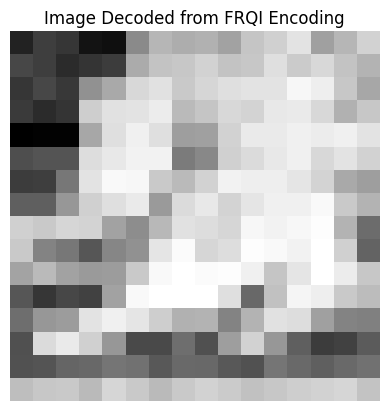

In [46]:
# 6. Decode image by sampling the quantum circuit
def frqi_measurement(angles, num_shots=100000):
    num_pixels = len(angles)
    num_address_qubits = int(np.log2(num_pixels))
    total_qubits = num_address_qubits + 1
    dev = qml.device("default.qubit", wires=total_qubits, shots=num_shots)

    @qml.qnode(dev)
    def circuit():
        address_wires = list(range(num_address_qubits))
        target_wire = total_qubits - 1

        for wire in address_wires:
            qml.Hadamard(wires=wire)

        for idx, theta in enumerate(angles):
            binary = format(idx, f'0{num_address_qubits}b')
            for i, bit in enumerate(binary):
                if bit == '0':
                    qml.PauliX(wires=address_wires[i])

            qml.ctrl(qml.RY, control=address_wires)(2 * theta, wires=target_wire)

            for i, bit in enumerate(binary):
                if bit == '0':
                    qml.PauliX(wires=address_wires[i])

        return qml.sample(wires=[*address_wires, target_wire])

    samples = circuit()
    pixel_counts = {}

    for sample in samples:
        *addr_bits, target_bit = sample
        addr_index = int("".join(map(str, addr_bits)), 2)
        if addr_index not in pixel_counts:
            pixel_counts[addr_index] = [0, 0]
        pixel_counts[addr_index][target_bit] += 1

    # Estimate intensity (as cos²(θ)) from target qubit measurement
    grayscale = []
    for i in range(num_pixels):
        zeros, ones = pixel_counts.get(i, [0, 0])
        prob_1 = ones / (zeros + ones + 1e-8)
        intensity = np.sqrt(prob_1)  # reverse of sin²(θ)
        grayscale.append(intensity)

    return np.array(grayscale)

# 7. Visualize reconstructed image
decoded = frqi_measurement(angles)
decoded_image = (decoded.reshape(16, 16) * 255).astype(np.uint8)

plt.imshow(decoded_image, cmap='gray')
plt.title("Image Decoded from FRQI Encoding")
plt.axis("off")
plt.show()


In [28]:
!pip install scikit-learn

     ---------------------------------------- 11.1/11.1 MB 1.0 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
from sklearn.metrics import mean_squared_error

original = (np.cos(angles))  # from arccos(normalized)
decoded_intensity = decoded

mse = mean_squared_error(original, decoded_intensity)
psnr = 20 * np.log10(1.0 / np.sqrt(mse))

print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")
# Compute mean and variance of decoded intensities
mean_intensity = np.mean(decoded)
variance_intensity = np.var(decoded)

print(f"Mean Intensity: {mean_intensity:.4f}")
print(f"Variance: {variance_intensity:.4f}")


Mean Squared Error (MSE): 0.232643
Peak Signal-to-Noise Ratio (PSNR): 6.33 dB
Mean Intensity: 0.8516
Variance: 0.0130


In [67]:
import pennylane as qml
from pennylane import numpy as np
from PIL import Image

# Step 1: Load and preprocess a grayscale image
def load_image(image_path, size=(4, 4)):
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    img = img.resize(size)
    img_array = np.asarray(img)
    img_array = img_array / 255.0  # Normalize to [0,1]
    return img_array.flatten()

# Step 2: Define the Hybrid QNode with EEG, Emotion, and Image Encoding
def hybrid_qnode(eeg_data, image_data, emotion_data):
    num_eeg = int(np.log2(len(eeg_data)))  # → 2 qubits for length-4 vector
    num_emotion = len(emotion_data)       # → 4 qubits
    num_frqi_pixels = len(image_data)
    num_frqi_address = int(np.log2(num_frqi_pixels))  # e.g., 16 pixels → 4 address qubits
    address_start = num_eeg + num_emotion
    data_wire = num_eeg + num_emotion + num_frqi_address
    total_wires = data_wire + 1

    dev = qml.device("default.qubit", wires=total_wires)

    @qml.qnode(dev)
    def circuit():
        # Amplitude encode EEG data
        qml.AmplitudeEmbedding(eeg_data, wires=range(num_eeg), normalize=True)

        # Angle encode Emotion data
        qml.AngleEmbedding(emotion_data * np.pi, wires=range(num_eeg, num_eeg + num_emotion), rotation="Y")

        # FRQI: Superposition over address qubits
        for i in range(num_frqi_address):
            qml.Hadamard(wires=address_start + i)

        # Controlled rotation based on address
        for idx, intensity in enumerate(image_data):
            bin_address = format(idx, f"0{num_frqi_address}b")
            ctrl_wires = [address_start + i for i, bit in enumerate(bin_address) if bit == '1']

            if ctrl_wires:
                qml.ctrl(qml.RY, control=ctrl_wires)(intensity * np.pi, wires=data_wire)
            else:
                qml.RY(intensity * np.pi, wires=data_wire)

        # Optional entanglement
        if total_wires > 5:
            qml.CNOT(wires=[num_eeg - 1, num_eeg])  # EEG to Emotion
        if total_wires > address_start:
            qml.CNOT(wires=[num_eeg + num_emotion - 1, address_start])  # Emotion to Image

        return qml.state()

    return circuit

# Step 3: Inputs
image_path = r"C:\Users\HP\encode\anantwave\fourier\cat_7.jpeg"
image_data = load_image(image_path, size=(4, 4))  # 16 grayscale values

eeg_data = np.array([0.2, 0.5, 0.3, 0.6])
eeg_data = eeg_data / np.linalg.norm(eeg_data)  # Normalized for amplitude encoding

emotion_data = np.array([0.1, 0.7, 0.4, 0.2])

# Step 4: Run Circuit
circuit = hybrid_qnode(eeg_data, image_data, emotion_data)
state = circuit()

# Step 5: Print results
print("Quantum State Output Shape:", state.shape)
print("Quantum State (partial):", state[:8])


Quantum State Output Shape: (2048,)
Quantum State (partial): [ 0.00793008+0.j  0.01841865+0.j -0.00701315+0.j  0.01878693+0.j
 -0.00441064+0.j  0.01956219+0.j -0.02002891+0.j -0.00098782+0.j]


In [70]:
# Step 6: Evaluation Metrics
# 1. Mean Amplitude
mean_amplitude = np.mean(state)
# 2. Variance of amplitudes
variance = np.var(state)
# 3. Norm of the state
norm = np.linalg.norm(state)
# 4. Entropy (Shannon entropy from probability amplitudes)
probabilities = np.abs(state) ** 2
entropy = -np.sum(probabilities * np.log2(probabilities + 1e-12))  # Add epsilon for numerical safety

# 5. Fidelity with |0...0⟩ state (first element is the amplitude of ground state)
fidelity_with_zero = np.abs(state[0]) ** 2

# Step 7: Print metrics
print("\n Quantum State Evaluation Metrics:")
print(f" State Norm: {norm:.6f}")
print(f" Mean Amplitude: {mean_amplitude}")
print(f" Variance: {variance:.8f}")
print(f" Entropy: {entropy:.4f} bits")
print(f" Fidelity with |0...0⟩ state: {fidelity_with_zero:.6f}")



 Quantum State Evaluation Metrics:
 State Norm: 1.000000
 Mean Amplitude: (-0.00040188231055385065+0j)
 Variance: 0.00048812
 Entropy: 8.4410 bits
 Fidelity with |0...0⟩ state: 0.000063
